In [1]:
import numpy as np
import matplotlib.pyplot as plt
import models as mod
import mod_visualization as mv
import mod_stimulation as ms
from models import logger
import inputools.Trajectory as it
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

2023-11-13 01:59:14 | logger set up
2023-11-13 01:59:14 | cache path = /Users/daniekru/Research/lab/cache/
2023-11-13 01:59:14 | OS: mac


@toolpack


In [2]:
from IPython.display import clear_output
def clf():
    clear_output(wait=True)

# 1D
---

**Settings**

In [15]:
N = 10
Nj = 20
T = 20*1000

## Input

In [16]:
# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = 1500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1
    j += 1

In [17]:
# input spikes
Sj = np.random.normal(0, 0.1, (T, Nj, 1)).clip(0, 1)

bin_size = 500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.normal(0, 1., size=(bin_size, 1)).clip(0, 1)
    i += 1
    j += 1

## Model 

In [165]:
net = mod.Network(N=N, Nj=Nj, learnable=True, lr=3e-2, 
                  wr_const=3.75,
                  wff_const=5.5,
                  wff_max=4.,
                  wff_min=0.1,
                  wff_beta=0.02,
                  wff_tau=50,
                  wr_tau=75,
                  tau_u=55,
                  syn_ff_min=0.04,
                 )

2023-11-10 19:41:34 | Network(N=16, Nj=25)


#### Connectivity

2023-11-10 17:18:57 | Recurrent weights set (10, 10)


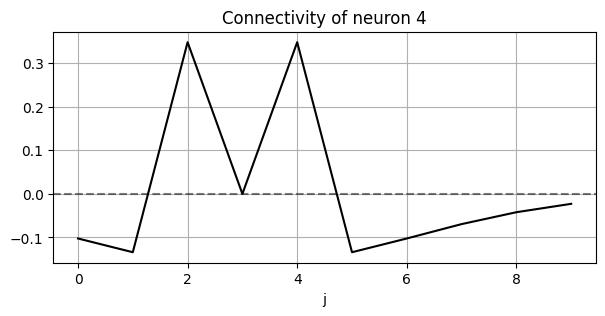

In [19]:
w = mod.mexican_hat_1D(N=N, A=1., B=.045, sigma_exc=.5, sigma_inh=3)

net.set_wrec(w)
#mv.plot_weight_matrix(net.Wrec)

plt.figure(figsize=(7, 3))
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()
plt.show()

In [20]:
net.Wrec.max()

0.347876651759281

## Simulation

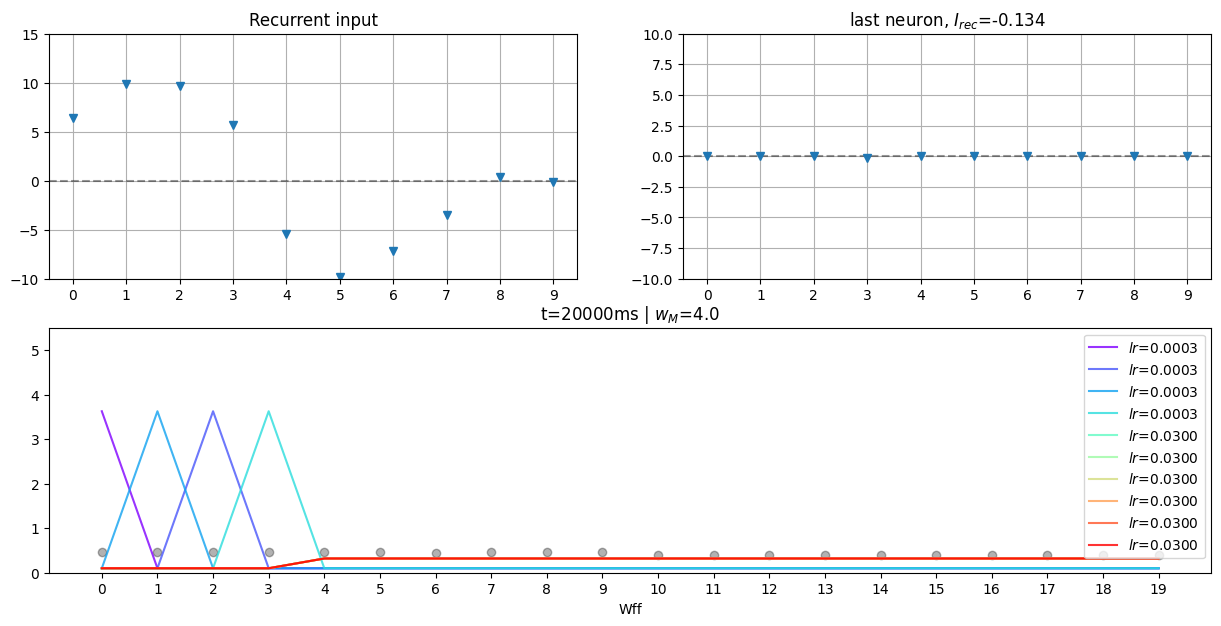

.


In [21]:
net.reset()

tp = 200

sp = np.zeros(Nj)
for t in range(T):

    net.step(Sj=Sj[t])
    sp += Sj[t, :, 0]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(15, 7))

        plt.subplot(221)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 1], 'v')
        plt.ylim((-10, 15))
        plt.grid()
        plt.xticks(range(N))
        plt.title("Recurrent input")

        plt.subplot(222)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 2], 'v')
        plt.ylim((-10, 10))
        plt.grid()
        plt.xticks(range(N))
        plt.title("last neuron, $I_{rec}$="+f"{net.record[:, 2].sum():.3f}")

        plt.subplot(212)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8, color=net.colors[i],
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms | $w_M$={net.wff_max}")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.legend(loc="upper right")
        plt.pause(0.01)

print(".")

In [314]:
net.record[:, 1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 2D
---

## Inputs

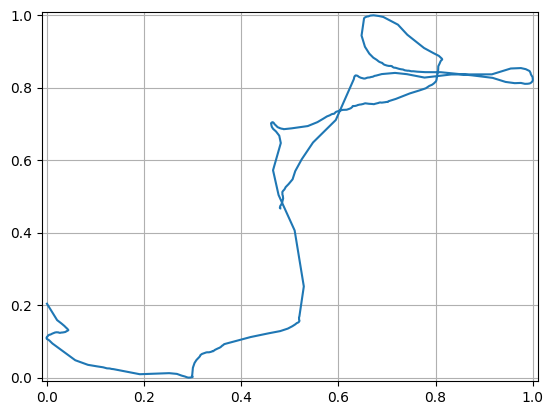

(1000, 2)


In [3]:
# Create an animal
animal = ms.AnimalTrajectory(dt=1, 
                             prob_turn=0.01, 
                             prob_speed=0.1,
                             prob_rest=0.01, 
                             day_cycle=True)

# Create a trajectory
trajectory = animal.make_trajectory(duration=1000, whole=False, dx=0.05)

# Plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.show()

print(trajectory.shape)

**Settings**

In [4]:
N = 9
Nj = 9
T = 10 # 1 step/s
bounds = (0, 1, 0, 1)

**Input layer**

In [12]:
layer = ms.InputLayer(N=Nj, kind='place', sigma=0.05, max_rate=100, min_rate=0)
logger.info(layer.__repr__())

Sj = layer.parse_trajectory(trajectory, timestep=100, mode='spike') 
logger.info(Sj.shape)

2023-11-13 02:01:36 | InputLayer(N=9, kind=place, sigma=0.05)
2023-11-13 02:01:37 | (100000, 9)


## Model

2023-11-13 02:07:44 | NetworkSimple(N=9, Nj=9) [b8qlb]


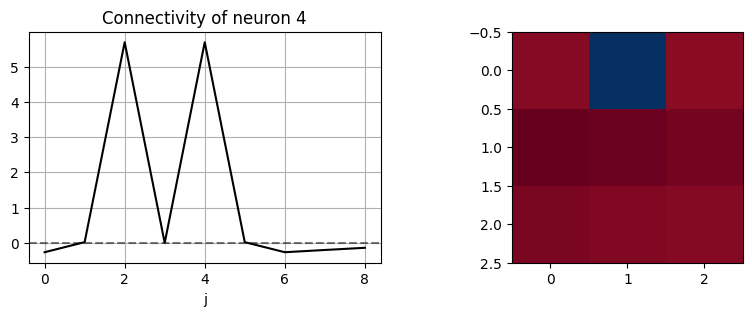

In [21]:
net = mod.NetworkSimple(
    N=N, Nj=Nj, lr=3e-2, 
                  wr_const=4.55,
                  wff_const=5.,
                  wff_max=4.5,
                  wff_min=0.01,
                  wff_beta=0.1,
                  wff_tau=50,
                  wr_tau=55,
                  tau_u=85,
                  syn_ff_min=0.045,
                  dim=1,
                  A=3.45,
                  B=0.085,
                  sigma_exc=.725,
                  sigma_inh=3.5
                 )

logger.info(net)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()

plt.subplot(122)
plt.imshow(net.Wrec[0].reshape(net.n, net.n), cmap="RdBu")

plt.show()

## Simulation on trajectory

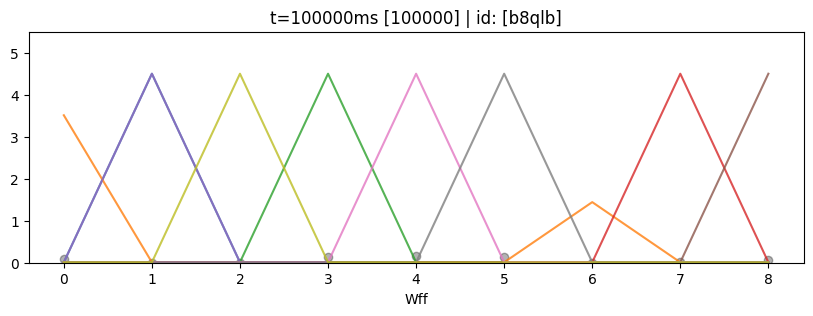

.


In [22]:
# Settings
#dataset = it.make_dataset(n_samples=3, animal=animal, layer=layer, duration=200, timestep=1000, dx=0.1)
net.reset()

tp = 1000

sp = np.zeros(Nj)
#Sj = dataset[0]
for t in range(len(Sj)):

    net.step(Sj=Sj[t].reshape(-1, 1))
    sp += Sj[t, :]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(10, 3))

        plt.subplot(111)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8,
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms [{len(Sj)}] | id: [{net.id}]")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.pause(0.01)

print(".")

## Analysis
---

### Input Layer

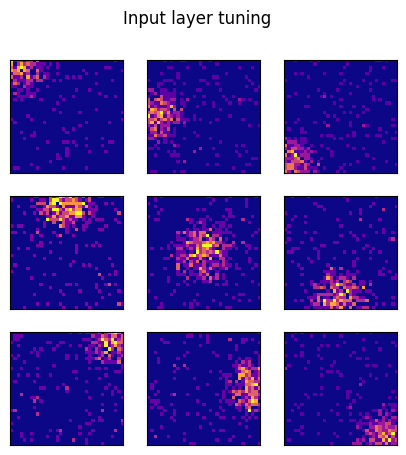

In [11]:
layer = ms.InputLayer(N=Nj, kind='place', bounds=(0.05, 0.95, 0.05, 0.95),
                      sigma=0.04, max_rate=300, min_rate=10)

rate = ms.get_network_tuning(layer=layer, mode='spike', 
                                dx=0.03, 
                                timestep=10)

fig, rows = plt.subplots(layer.n, layer.n, figsize=(5, 5))

fig.suptitle("Input layer tuning")
i = 0
for cols in rows:
    for ax in cols:
        ax.imshow(rate[:, i].reshape(int(np.sqrt(len(rate))), int(np.sqrt(len(rate)))), cmap='plasma')
        i += 1
        ax.set_xticks(())
        ax.set_yticks(())
        
plt.show()

### PC network

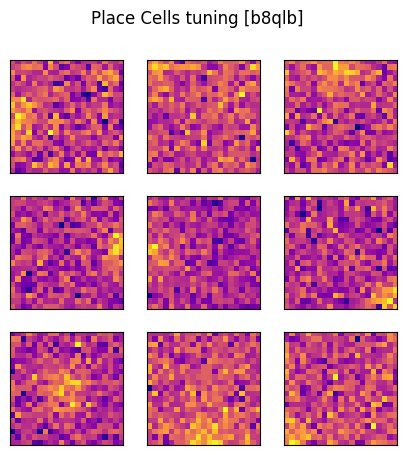

In [25]:
net.set_plastic(plastic=False)
rate_pc = it.get_network_tuning(model=net, layer=layer, mode='spike', 
                                          dx=0.05, 
                                          timestep=1000,
                                reset=False
                               )

nrows = net.n
ncols = net.n
fig, rows = plt.subplots(nrows, ncols, figsize=(5, 5))
fig.suptitle(f"Place Cells tuning [{net.id}]")
i = 0
for cols in rows:
    for ax in cols:
        ax.imshow(rate_pc[:, i].reshape(int(np.sqrt(len(rate_pc))), 
                                        int(np.sqrt(len(rate_pc)))),
                                        cmap='plasma')
        i += 1
        ax.set_xticks(())
        ax.set_yticks(())
        
plt.show()

**FeedFoward Weights**

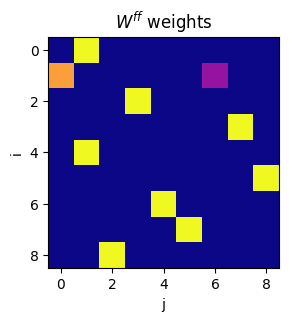

In [26]:
plt.figure(figsize=(3, 3))
plt.imshow(net.Wff, cmap="plasma")
plt.title("$W^{ff}$ weights")
plt.xlabel('j')
plt.ylabel('i')
plt.show()

In [18]:
net.Wff

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

**Dataset**

In [7]:
dataset = it.make_dataset(n_samples=3, animal=animal, layer=layer, durabtion=100, dx=0.1)

In [8]:
len(dataset)

3

# Old
---

In [ ]:
# Parameters
#grid_size = int(np.sqrt(Nj))  # Size of the grid (N x N)


# Generate the forward-only walk trajectory and activationsiiiiiii
forward_trajectory, forward_activations = ms.generate_walk_trajectory(steps=10, layer=layer, verbose=True)

# Visualize the forward-only trajectory and neuron activations
ms.visualize_trajectory_and_activations(forward_trajectory, forward_activations, bounds)

logger.info(f"Trajectory: \n{forward_trajectory.T}")
logger.info(f"Activations shape: {len(forward_activations)}, {forward_activations[0].shape}")

# make spikes
Sj = ms.make_spiking_trajectory(Nj=Nj, activations=forward_activations, stm_duration=1000, 
                                pause_time=100, base_rate=10, stm_rate=300, binary=True)

# Connectivity
---

**1D**

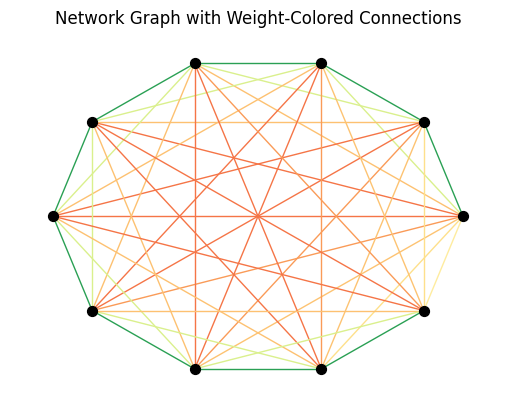

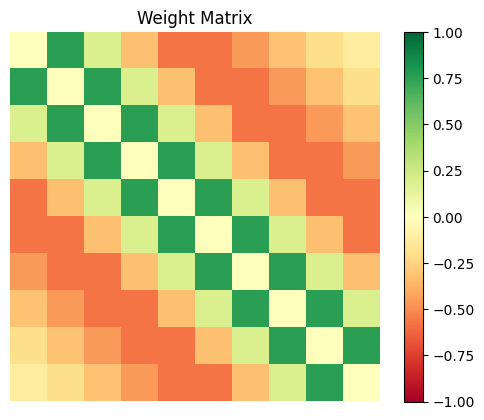

In [44]:
# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_1D(N=10, A=2.5, B=1.5, sigma_exc=2, sigma_inh=4.)

# plot
mv.plot_graph_colored_1D(w)
mv.plot_weight_matrix(w)

**2D**

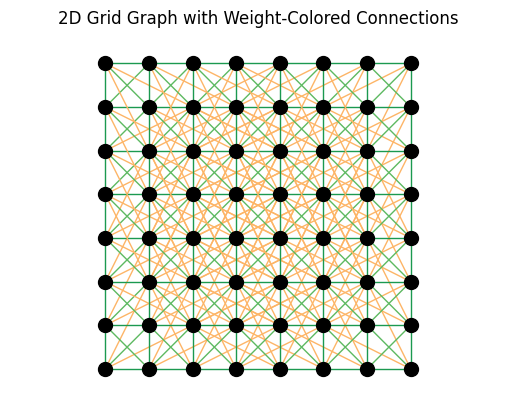

In [72]:
# Define a smaller network for clearer visualization
dims = (8, 8)
A = 2.  # Excitatory strength
B = 1.  # Inhibitory strength
sigma_exc = 2.0  # Excitatory spread
sigma_inh = 4.0  # Inhibitory spread

# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_2D(dims, A, B, sigma_exc, sigma_inh)

# plot
mv.plot_graph_colored_2D(w, dims, threshold=0.37)

In [294]:
soft = lambda x, b: np.exp(b*x) / np.exp(b*x).sum(axis=0)

In [307]:

sw = soft(w, b=0.05)
print(w, '\n\nsoftmax:\n', np.around(sw, 3), '\n\nmultiplers:\n', sw / sw.max(axis=0))

[[0.        0.        2.        0.        0.       ]
 [0.        0.        0.        0.        2.       ]
 [0.2657752 0.        1.7342248 0.        0.       ]] 

softmax:
 [[0.332 0.333 0.346 0.333 0.322]
 [0.332 0.333 0.313 0.333 0.356]
 [0.336 0.333 0.341 0.333 0.322]] 

multiplers:
 [[0.98679915 1.         1.         1.         0.90483742]
 [0.98679915 1.         0.90483742 1.         1.        ]
 [1.         1.         0.98679915 1.         0.90483742]]


In [278]:
sw / sw.max(axis=0) * w

array([[0.        , 0.        , 2.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 2.        ],
       [0.2657752 , 0.        , 1.32947658, 0.        , 0.        ]])

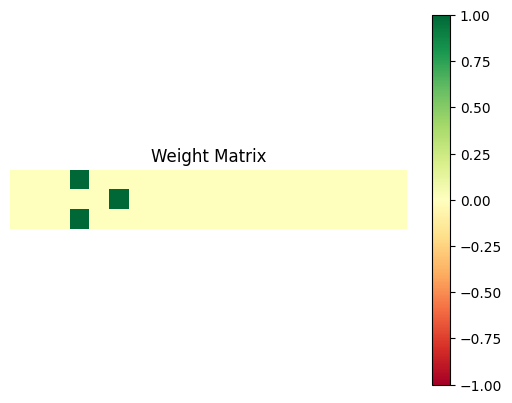

In [233]:
mv.plot_weight_matrix(net.Wff)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


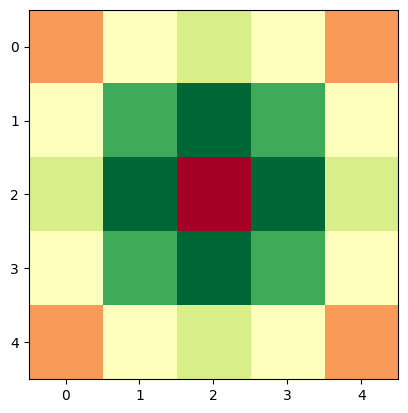

In [10]:
N = 25
ns = int(np.sqrt(N))
A = 2
B = 0.5
sigma_exc = 2
sigma_inh = 4

w = np.zeros((N, N))
ids = [*mod.iterprod(range(ns), range(ns))]
print(ids)

for i in range(N):
    #print()
    for j in range(N):
        if i == j:
            #print("         0          ", end="")
            #print(end="  .     ")
            continue
        #print(f"({ids[i][0]}-{ids[j][0]})^2 + ({ids[i][1]}-{ids[j][1]})^2   ", end="")
        dij = np.sqrt((ids[i][0]-ids[j][0])**2 + (ids[i][1]-ids[j][1])**2)
        wij = A * np.exp(-(dij**2)/(2*sigma_exc**2)) - B * np.exp(-(dij**2)/(2*sigma_inh**2))
        w[i,j] = wij
        #print(f"{wij:.2f}", end="    ")

#plt.imshow(w, cmap='Blues')
#plt.show()
plt.imshow(w[12].reshape(ns, ns), cmap="RdYlGn");
#print('\n\n', w)